# Cost Sensitivity Analysis

This notebook performs cost sensitivity analysis by running multiple experiments with varying parameters and analyzing how different factors affect token usage, runtime, and cost.

## Overview

This experiment driver allows you to:
- Define multiple experiment configurations with varying parameters
- Run experiments automatically
- Calculate costs using API pricing or local GPU pricing
- Perform sensitivity analysis to understand parameter impacts
- Generate comprehensive visualizations

## How to Use

1. **Define Experiments**: Edit the experiment configurations in Section 2
2. **Run Experiments**: Execute Section 4 to run all experiments
3. **Analyze Results**: Review tables and plots in Sections 5-8
4. **Add New Experiments**: Simply add new dictionaries to the `experiments` list

## Experiment Parameters

Each experiment can vary:
- **Model configuration**: generation and embedding models
- **Workload**: number of documents, chunk size, questions per doc
- **Runtime**: concurrency level
- **Pricing**: API mode (per-token) or local mode (per-hour)


## Section 1: Setup and Imports


In [1]:
# Import standard library modules
import json
import sys
import time
from pathlib import Path
from typing import Dict, List, Optional, Any

# Add the src directory to Python path
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

# Import our custom modules
from src.config import Config
from src.pipeline import (
    load_document, 
    chunk_text, 
    embed_chunks, 
    generate_questions,
    save_chunks,
    save_metrics
)
from src.timing_metrics import MetricsStore
from src.reporting import aggregate_metrics, load_metrics
from src.token_accounting import count_tokens

# Import data analysis and visualization libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set up matplotlib for better-looking plots
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except OSError:
    try:
        plt.style.use('seaborn-darkgrid')
    except OSError:
        plt.style.use('default')
%matplotlib inline

print("Modules imported successfully!")


Modules imported successfully!


In [2]:
# Set up paths
base_config = Config()
experiments_dir = base_config.results_dir / "experiments"
experiments_dir.mkdir(parents=True, exist_ok=True)

print(f"Results directory: {base_config.results_dir}")
print(f"Experiments directory: {experiments_dir}")

# Document path (using MobyDick.txt as example)
document_path = project_root / "MobyDick.txt"
print(f"Document path: {document_path}")


Results directory: results
Experiments directory: results/experiments
Document path: /Users/tylergoble/Documents/GitHub/GenerativeAI-Cost-Estimator/MobyDick.txt


## Section 2: Experiment Configuration

Define your experiments here. Each experiment is a dictionary with the following keys:

- `name`: Unique identifier for the experiment
- `gen_model`: Generation model name (e.g., "gemma3:1b")
- `embed_model`: Embedding model name (e.g., "embeddinggemma")
- `num_docs`: Number of documents/chunks to process (use subset of available chunks)
- `chunk_size`: Chunk size in tokens
- `chunk_overlap`: Overlap between chunks in tokens
- `num_questions_per_doc`: Number of questions to generate per chunk
- `concurrency`: Number of parallel operations (1 = sequential)
- `pricing`: Dictionary with pricing mode and parameters
  - For API mode: `{"mode": "api", "price_per_1k_tokens_input": 0.5, "price_per_1k_tokens_output": 1.5}`
  - For local mode: `{"mode": "local", "dollars_per_gpu_hour": 1.5}`

**Note**: For `num_docs`, we'll use a subset of chunks from the existing document. If you want to process all chunks, set `num_docs` to a large number or use `None`.


In [ ]:
# Define experiment configurations
# Add or modify experiments here to test different parameter combinations

experiments = [
    {
        "name": "baseline_gemma3_1b",
        "gen_model": "gemma3:1b",
        "embed_model": "embeddinggemma",
        "num_docs": 10,  # Process first 10 chunks
        "chunk_size": 512,
        "chunk_overlap": 50,
        "num_questions_per_doc": 2,
        "concurrency": 1,
        "pricing": {
            "mode": "local",
            "dollars_per_gpu_hour": 1.50
        }
    },
    {
        "name": "large_chunks_512",
        "gen_model": "gemma3:1b",
        "embed_model": "embeddinggemma",
        "num_docs": 10,
        "chunk_size": 512,
        "chunk_overlap": 50,
        "num_questions_per_doc": 3,
        "concurrency": 1,
        "pricing": {
            "mode": "api",
            "price_per_1k_tokens_input": 0.00250,
            "price_per_1k_tokens_output": 0.01000
        }
    },
    {
        "name": "small_chunks_256",
        "gen_model": "gemma3:1b",
        "embed_model": "embeddinggemma",
        "num_docs": 10,
        "chunk_size": 256,
        "chunk_overlap": 25,
        "num_questions_per_doc": 2,
        "concurrency": 1,
        "pricing": {
            "mode": "api",
            "price_per_1k_tokens_input": 0.00250,
            "price_per_1k_tokens_output": 0.01000
        }
    },
    {
        "name": "more_questions",
        "gen_model": "gemma3:1b",
        "embed_model": "embeddinggemma",
        "num_docs": 10,
        "chunk_size": 512,
        "chunk_overlap": 50,
        "num_questions_per_doc": 5,
        "concurrency": 1,
        "pricing": {
            "mode": "api",
            "price_per_1k_tokens_input": 0.00250,
            "price_per_1k_tokens_output": 0.01000
        }
    },
    {
        "name": "more_docs_20",
        "gen_model": "gemma3:1b",
        "embed_model": "embeddinggemma",
        "num_docs": 20,
        "chunk_size": 512,
        "chunk_overlap": 50,
        "num_questions_per_doc": 2,
        "concurrency": 1,
        "pricing": {
            "mode": "api",
            "price_per_1k_tokens_input": 0.00250,
            "price_per_1k_tokens_output": 0.01000
        }
    },
    # Additional experiments with 3x num_docs
    {
        "name": "baseline_gemma3_1b_30docs",
        "gen_model": "gemma3:1b",
        "embed_model": "embeddinggemma",
        "num_docs": 30,  # 10 * 3
        "chunk_size": 512,
        "chunk_overlap": 50,
        "num_questions_per_doc": 2,
        "concurrency": 1,
        "pricing": {
            "mode": "local",
            "dollars_per_gpu_hour": 1.50
        }
    },
    {
        "name": "large_chunks_512_30docs",
        "gen_model": "gemma3:1b",
        "embed_model": "embeddinggemma",
        "num_docs": 30,  # 10 * 3
        "chunk_size": 512,
        "chunk_overlap": 50,
        "num_questions_per_doc": 3,
        "concurrency": 1,
        "pricing": {
            "mode": "api",
            "price_per_1k_tokens_input": 0.00250,
            "price_per_1k_tokens_output": 0.01000
        }
    },
    {
        "name": "small_chunks_256_30docs",
        "gen_model": "gemma3:1b",
        "embed_model": "embeddinggemma",
        "num_docs": 30,  # 10 * 3
        "chunk_size": 256,
        "chunk_overlap": 25,
        "num_questions_per_doc": 2,
        "concurrency": 1,
        "pricing": {
            "mode": "api",
            "price_per_1k_tokens_input": 0.00250,
            "price_per_1k_tokens_output": 0.01000
        }
    },
    {
        "name": "more_questions_30docs",
        "gen_model": "gemma3:1b",
        "embed_model": "embeddinggemma",
        "num_docs": 30,  # 10 * 3
        "chunk_size": 512,
        "chunk_overlap": 50,
        "num_questions_per_doc": 5,
        "concurrency": 1,
        "pricing": {
            "mode": "api",
            "price_per_1k_tokens_input": 0.00250,
            "price_per_1k_tokens_output": 0.01000
        }
    },
    {
        "name": "more_docs_60",
        "gen_model": "gemma3:1b",
        "embed_model": "embeddinggemma",
        "num_docs": 60,  # 20 * 3
        "chunk_size": 512,
        "chunk_overlap": 50,
        "num_questions_per_doc": 2,
        "concurrency": 1,
        "pricing": {
            "mode": "api",
            "price_per_1k_tokens_input": 0.00250,
            "price_per_1k_tokens_output": 0.01000
        }
    },
    # Experiments with gemma3:4b model (mirroring the above 10 experiments)
    {
        "name": "baseline_gemma3_4b",
        "gen_model": "gemma3:4b",
        "embed_model": "embeddinggemma",
        "num_docs": 10,
        "chunk_size": 512,
        "chunk_overlap": 50,
        "num_questions_per_doc": 2,
        "concurrency": 1,
        "pricing": {
            "mode": "local",
            "dollars_per_gpu_hour": 1.50
        }
    },
    {
        "name": "large_chunks_512_4b",
        "gen_model": "gemma3:4b",
        "embed_model": "embeddinggemma",
        "num_docs": 10,
        "chunk_size": 512,
        "chunk_overlap": 50,
        "num_questions_per_doc": 3,
        "concurrency": 1,
        "pricing": {
            "mode": "api",
            "price_per_1k_tokens_input": 0.00250,
            "price_per_1k_tokens_output": 0.01000
        }
    },
    {
        "name": "small_chunks_256_4b",
        "gen_model": "gemma3:4b",
        "embed_model": "embeddinggemma",
        "num_docs": 10,
        "chunk_size": 256,
        "chunk_overlap": 25,
        "num_questions_per_doc": 2,
        "concurrency": 1,
        "pricing": {
            "mode": "api",
            "price_per_1k_tokens_input": 0.00250,
            "price_per_1k_tokens_output": 0.01000
        }
    },
    {
        "name": "more_questions_4b",
        "gen_model": "gemma3:4b",
        "embed_model": "embeddinggemma",
        "num_docs": 10,
        "chunk_size": 512,
        "chunk_overlap": 50,
        "num_questions_per_doc": 5,
        "concurrency": 1,
        "pricing": {
            "mode": "api",
            "price_per_1k_tokens_input": 0.00250,
            "price_per_1k_tokens_output": 0.01000
        }
    },
    {
        "name": "more_docs_20_4b",
        "gen_model": "gemma3:4b",
        "embed_model": "embeddinggemma",
        "num_docs": 20,
        "chunk_size": 512,
        "chunk_overlap": 50,
        "num_questions_per_doc": 2,
        "concurrency": 1,
        "pricing": {
            "mode": "api",
            "price_per_1k_tokens_input": 0.00250,
            "price_per_1k_tokens_output": 0.01000
        }
    },
    {
        "name": "baseline_gemma3_4b_30docs",
        "gen_model": "gemma3:4b",
        "embed_model": "embeddinggemma",
        "num_docs": 30,  # 10 * 3
        "chunk_size": 512,
        "chunk_overlap": 50,
        "num_questions_per_doc": 2,
        "concurrency": 1,
        "pricing": {
            "mode": "local",
            "dollars_per_gpu_hour": 1.50
        }
    },
    {
        "name": "large_chunks_512_30docs_4b",
        "gen_model": "gemma3:4b",
        "embed_model": "embeddinggemma",
        "num_docs": 30,  # 10 * 3
        "chunk_size": 512,
        "chunk_overlap": 50,
        "num_questions_per_doc": 3,
        "concurrency": 1,
        "pricing": {
            "mode": "api",
            "price_per_1k_tokens_input": 0.00250,
            "price_per_1k_tokens_output": 0.01000
        }
    },
    {
        "name": "small_chunks_256_30docs_4b",
        "gen_model": "gemma3:4b",
        "embed_model": "embeddinggemma",
        "num_docs": 30,  # 10 * 3
        "chunk_size": 256,
        "chunk_overlap": 25,
        "num_questions_per_doc": 2,
        "concurrency": 1,
        "pricing": {
            "mode": "api",
            "price_per_1k_tokens_input": 0.00250,
            "price_per_1k_tokens_output": 0.01000
        }
    },
    {
        "name": "more_questions_30docs_4b",
        "gen_model": "gemma3:4b",
        "embed_model": "embeddinggemma",
        "num_docs": 30,  # 10 * 3
        "chunk_size": 512,
        "chunk_overlap": 50,
        "num_questions_per_doc": 5,
        "concurrency": 1,
        "pricing": {
            "mode": "api",
            "price_per_1k_tokens_input": 0.00250,
            "price_per_1k_tokens_output": 0.01000
        }
    },
    {
        "name": "more_docs_60_4b",
        "gen_model": "gemma3:4b",
        "embed_model": "embeddinggemma",
        "num_docs": 60,  # 20 * 3
        "chunk_size": 512,
        "chunk_overlap": 50,
        "num_questions_per_doc": 2,
        "concurrency": 1,
        "pricing": {
            "mode": "api",
            "price_per_1k_tokens_input": 0.00250,
            "price_per_1k_tokens_output": 0.01000
        }
    }
]

print(f"Defined {len(experiments)} experiments")
for exp in experiments:
    print(f"  - {exp['name']}")


Defined 5 experiments
  - baseline_gemma3_1b
  - large_chunks_512
  - small_chunks_256
  - more_questions
  - more_docs_20


In [4]:
def calculate_costs(metrics: Dict[str, Any], pricing_config: Dict[str, Any]) -> Dict[str, float]:
    """
    Calculate costs based on pricing mode and metrics.
    
    Args:
        metrics: Dictionary with aggregated metrics (from aggregate_metrics)
        pricing_config: Pricing configuration dict with 'mode' and pricing parameters
    
    Returns:
        Dictionary with cost breakdown
    """
    # Extract token and time metrics
    embedding_tokens = metrics.get('embedding', {}).get('total_tokens', 0)
    inference_prompt_tokens = metrics.get('inference', {}).get('total_prompt_tokens', 0)
    inference_response_tokens = metrics.get('inference', {}).get('total_response_tokens', 0)
    
    total_input_tokens = embedding_tokens + inference_prompt_tokens
    total_output_tokens = inference_response_tokens
    total_tokens = total_input_tokens + total_output_tokens
    
    total_runtime_seconds = metrics.get('overall', {}).get('total_time_seconds', 0)
    
    # Calculate costs based on pricing mode
    mode = pricing_config.get('mode', 'local')
    
    if mode == 'api':
        # API pricing: per-token pricing
        price_per_1k_input = pricing_config.get('price_per_1k_tokens_input', 0.0)
        price_per_1k_output = pricing_config.get('price_per_1k_tokens_output', 0.0)
        
        cost_input = (total_input_tokens / 1000.0) * price_per_1k_input
        cost_output = (total_output_tokens / 1000.0) * price_per_1k_output
        total_cost = cost_input + cost_output
        
        return {
            'total_input_tokens': total_input_tokens,
            'total_output_tokens': total_output_tokens,
            'total_tokens': total_tokens,
            'total_runtime_seconds': total_runtime_seconds,
            'cost_input': cost_input,
            'cost_output': cost_output,
            'total_cost': total_cost,
            'cost_per_1k_tokens': (total_cost / total_tokens * 1000) if total_tokens > 0 else 0,
            'pricing_mode': 'api'
        }
    
    else:  # local mode
        # Local pricing: per-hour pricing
        dollars_per_hour = pricing_config.get('dollars_per_gpu_hour', 0.0)
        runtime_hours = total_runtime_seconds / 3600.0
        total_cost = runtime_hours * dollars_per_hour
        
        return {
            'total_input_tokens': total_input_tokens,
            'total_output_tokens': total_output_tokens,
            'total_tokens': total_tokens,
            'total_runtime_seconds': total_runtime_seconds,
            'runtime_hours': runtime_hours,
            'total_cost': total_cost,
            'cost_per_1k_tokens': (total_cost / total_tokens * 1000) if total_tokens > 0 else 0,
            'pricing_mode': 'local'
        }


print("Cost calculation function defined")


Cost calculation function defined


In [5]:
def run_experiment(exp_config: Dict[str, Any], document_path: Path, 
                  experiments_dir: Path, reuse_chunks: bool = True) -> Dict[str, Any]:
    """
    Run a single experiment.
    
    This function:
    1. Creates a Config object from the experiment configuration
    2. Loads and chunks the document (or reuses existing chunks)
    3. Runs embedding pipeline for the specified number of chunks
    4. Runs question generation pipeline
    5. Collects and aggregates all metrics
    6. Calculates costs
    7. Returns experiment results
    
    Args:
        exp_config: Experiment configuration dictionary
        document_path: Path to the document file
        experiments_dir: Directory to save experiment results
        reuse_chunks: If True, try to reuse existing chunks from previous runs
    
    Returns:
        Dictionary with experiment results including metrics and costs
    """
    print(f"\n{'='*70}")
    print(f"Running experiment: {exp_config['name']}")
    print(f"{'='*70}")
    
    start_time = time.time()
    
    # Create Config object from experiment configuration
    config = Config(
        embedding_model=exp_config['embed_model'],
        generation_model=exp_config['gen_model'],
        chunk_size_tokens=exp_config['chunk_size'],
        chunk_overlap_tokens=exp_config.get('chunk_overlap', 50),
        chunking_strategy='fixed_token_window'
    )
    
    # Create metrics store for this experiment
    metrics_store = MetricsStore()
    
    # Load and chunk document (or reuse existing chunks)
    # For efficiency, we can reuse chunks if they exist and match our config
    chunks_path = config.get_chunks_path()
    
    if reuse_chunks and chunks_path.exists():
        # Try to load existing chunks
        try:
            with open(chunks_path, 'r') as f:
                all_chunks = json.load(f)
            print(f"Loaded {len(all_chunks)} existing chunks")
        except:
            all_chunks = None
    else:
        all_chunks = None
    
    if all_chunks is None:
        # Need to create chunks
        print("Loading and chunking document...")
        text = load_document(document_path)
        all_chunks = chunk_text(text, config)
        print(f"Created {len(all_chunks)} chunks")
    
    # Select subset of chunks based on num_docs
    num_docs = exp_config.get('num_docs')
    if num_docs is None or num_docs > len(all_chunks):
        selected_chunks = all_chunks
    else:
        selected_chunks = all_chunks[:num_docs]
    
    print(f"Processing {len(selected_chunks)} chunks for this experiment")
    
    # Extract chunk text (remove embeddings if present to save memory)
    chunks_for_embedding = []
    for chunk in selected_chunks:
        chunk_copy = {k: v for k, v in chunk.items() if k != 'embedding'}
        chunks_for_embedding.append(chunk_copy)
    
    # Run embedding pipeline
    print("Embedding chunks...")
    embedded_chunks = embed_chunks(chunks_for_embedding, config, metrics_store)
    print(f"Embedded {len(embedded_chunks)} chunks")
    
    # Run question generation pipeline
    print(f"Generating questions ({exp_config['num_questions_per_doc']} per chunk)...")
    all_questions = []
    
    # Process chunks sequentially (concurrency can be added later if needed)
    for chunk in embedded_chunks:
        questions = generate_questions(
            chunk,
            exp_config['num_questions_per_doc'],
            config,
            metrics_store
        )
        all_questions.extend(questions)
    
    print(f"Generated {len(all_questions)} questions")
    
    # Aggregate metrics
    # Convert metrics store to DataFrame for aggregation
    import pandas as pd
    metrics_df = pd.DataFrame(metrics_store.metrics)
    aggregated = aggregate_metrics(metrics_df)
    
    # Calculate costs
    costs = calculate_costs(aggregated, exp_config['pricing'])
    
    # Calculate additional metrics
    total_questions = len(all_questions)
    total_chunks = len(embedded_chunks)
    
    # Calculate derived metrics
    tokens_per_second = aggregated.get('overall', {}).get('tokens_per_second', 0)
    
    # Build experiment results
    results = {
        'experiment_name': exp_config['name'],
        'gen_model': exp_config['gen_model'],
        'embed_model': exp_config['embed_model'],
        'num_docs': len(selected_chunks),
        'chunk_size': exp_config['chunk_size'],
        'chunk_overlap': exp_config.get('chunk_overlap', 50),
        'num_questions_per_doc': exp_config['num_questions_per_doc'],
        'total_questions': total_questions,
        'concurrency': exp_config.get('concurrency', 1),
        'total_input_tokens': costs['total_input_tokens'],
        'total_output_tokens': costs['total_output_tokens'],
        'total_tokens': costs['total_tokens'],
        'total_runtime_seconds': costs['total_runtime_seconds'],
        'tokens_per_second': tokens_per_second,
        'total_cost': costs['total_cost'],
        'cost_per_1k_tokens': costs['cost_per_1k_tokens'],
        'cost_per_document': costs['total_cost'] / len(selected_chunks) if len(selected_chunks) > 0 else 0,
        'cost_per_question': costs['total_cost'] / total_questions if total_questions > 0 else 0,
        'pricing_mode': costs['pricing_mode'],
        'aggregated_metrics': aggregated,
        'costs': costs
    }
    
    # Save experiment metrics
    exp_metrics_path = experiments_dir / f"{exp_config['name']}_metrics.json"
    save_metrics(metrics_store, exp_metrics_path)
    print(f"Saved metrics to {exp_metrics_path}")
    
    elapsed = time.time() - start_time
    print(f"Experiment completed in {elapsed:.2f} seconds")
    
    return results


print("Experiment runner function defined")


Experiment runner function defined


## Section 4: Experiment Execution Loop

Run all experiments. Set `skip_existing=True` to skip experiments that have already been run (checks for existing result files).


In [6]:
# Configuration for execution
skip_existing = True  # Set to False to re-run all experiments
reuse_chunks = True   # Set to True to reuse existing chunks for faster execution

# Store all experiment results
all_results = []

print(f"Running {len(experiments)} experiments...")
print(f"Skip existing: {skip_existing}")
print(f"Reuse chunks: {reuse_chunks}\n")

for i, exp_config in enumerate(experiments, 1):
    exp_name = exp_config['name']
    exp_metrics_path = experiments_dir / f"{exp_name}_metrics.json"
    
    # Check if experiment already exists
    if skip_existing and exp_metrics_path.exists():
        print(f"\n[{i}/{len(experiments)}] Skipping {exp_name} (results already exist)")
        print(f"  To re-run, delete: {exp_metrics_path}")
        continue
    
    try:
        print(f"\n[{i}/{len(experiments)}] Running {exp_name}...")
        result = run_experiment(exp_config, document_path, experiments_dir, reuse_chunks=reuse_chunks)
        all_results.append(result)
        print(f"✓ {exp_name} completed successfully")
    except Exception as e:
        print(f"✗ {exp_name} failed with error: {e}")
        import traceback
        traceback.print_exc()
        # Continue with next experiment
        continue

print(f"\n{'='*70}")
print(f"Completed {len(all_results)} experiments successfully")
print(f"{'='*70}")


Running 5 experiments...
Skip existing: True
Reuse chunks: True


[1/5] Running baseline_gemma3_1b...

Running experiment: baseline_gemma3_1b
Loaded 772 existing chunks
Processing 10 chunks for this experiment
Embedding chunks...
Embedded 10 chunks
Generating questions (2 per chunk)...
Generated 20 questions
Saved metrics to results/experiments/baseline_gemma3_1b_metrics.json
Experiment completed in 18.27 seconds
✓ baseline_gemma3_1b completed successfully

[2/5] Running large_chunks_512...

Running experiment: large_chunks_512
Loaded 772 existing chunks
Processing 10 chunks for this experiment
Embedding chunks...
Embedded 10 chunks
Generating questions (3 per chunk)...
Generated 30 questions
Saved metrics to results/experiments/large_chunks_512_metrics.json
Experiment completed in 17.48 seconds
✓ large_chunks_512 completed successfully

[3/5] Running small_chunks_256...

Running experiment: small_chunks_256
Loaded 772 existing chunks
Processing 10 chunks for this experiment
Embedding 

## Section 5: Results Aggregation

Build a summary DataFrame with all experiment results.


In [7]:
# Build summary DataFrame
if all_results:
    # Extract key metrics from each result
    summary_data = []
    for result in all_results:
        summary_data.append({
            'experiment_name': result['experiment_name'],
            'gen_model': result['gen_model'],
            'embed_model': result['embed_model'],
            'num_docs': result['num_docs'],
            'chunk_size': result['chunk_size'],
            'chunk_overlap': result['chunk_overlap'],
            'num_questions_per_doc': result['num_questions_per_doc'],
            'total_questions': result['total_questions'],
            'concurrency': result['concurrency'],
            'total_input_tokens': result['total_input_tokens'],
            'total_output_tokens': result['total_output_tokens'],
            'total_tokens': result['total_tokens'],
            'total_runtime_seconds': result['total_runtime_seconds'],
            'tokens_per_second': result['tokens_per_second'],
            'total_cost': result['total_cost'],
            'cost_per_1k_tokens': result['cost_per_1k_tokens'],
            'cost_per_document': result['cost_per_document'],
            'cost_per_question': result['cost_per_question'],
            'pricing_mode': result['pricing_mode']
        })
    
    summary_df = pd.DataFrame(summary_data)
    
    # Save summary to CSV
    summary_path = experiments_dir / "summary.csv"
    summary_df.to_csv(summary_path, index=False)
    print(f"Summary saved to {summary_path}")
    
    # Display summary table
    print(f"\nSummary of {len(summary_df)} experiments:")
    print("="*100)
    display(summary_df)
else:
    print("No results to aggregate. Run experiments first.")
    summary_df = pd.DataFrame()


Summary saved to results/experiments/summary.csv

Summary of 5 experiments:


,experiment_name,gen_model,embed_model,num_docs,chunk_size,chunk_overlap,num_questions_per_doc,total_questions,concurrency,total_input_tokens,total_output_tokens,total_tokens,total_runtime_seconds,tokens_per_second,total_cost,cost_per_1k_tokens,cost_per_document,cost_per_question,pricing_mode
0,baseline_gemma3_1b,gemma3:1b,embeddinggemma,10,512,50,2,20,1,15367,286,15653,17.973296,870.903148,0.007489,0.000478,0.000749,0.000374,local
1,large_chunks_512,gemma3:1b,embeddinggemma,10,512,50,3,30,1,20597,429,21026,17.336664,1212.805416,10.942000,0.520403,1.094200,0.364733,api
2,small_chunks_256,gemma3:1b,embeddinggemma,10,256,25,2,20,1,15367,306,15673,15.926884,984.059395,8.142500,0.519524,0.814250,0.407125,api
3,more_questions,gemma3:1b,embeddinggemma,10,512,50,5,50,1,31057,635,31692,20.755310,1526.934562,16.481000,0.520037,1.648100,0.329620,api
4,more_docs_20,gemma3:1b,embeddinggemma,20,512,50,2,40,1,30555,620,31175,28.365273,1099.055185,16.207500,0.519888,0.810375,0.405187,api


## Section 6: Cost Calculation and Analysis

Display formatted summary tables with key metrics.


In [8]:
if not summary_df.empty:
    # Create a nicely formatted summary table
    print("Cost Summary by Experiment")
    print("="*100)
    
    # Select key columns for display
    display_cols = [
        'experiment_name', 'gen_model', 'num_docs', 'chunk_size', 
        'total_tokens', 'total_runtime_seconds', 'total_cost',
        'cost_per_1k_tokens', 'cost_per_document', 'cost_per_question'
    ]
    
    # Format numeric columns for better readability
    formatted_df = summary_df[display_cols].copy()
    formatted_df['total_tokens'] = formatted_df['total_tokens'].apply(lambda x: f"{x:,.0f}")
    formatted_df['total_runtime_seconds'] = formatted_df['total_runtime_seconds'].apply(lambda x: f"{x:.2f}")
    formatted_df['total_cost'] = formatted_df['total_cost'].apply(lambda x: f"${x:.4f}")
    formatted_df['cost_per_1k_tokens'] = formatted_df['cost_per_1k_tokens'].apply(lambda x: f"${x:.4f}")
    formatted_df['cost_per_document'] = formatted_df['cost_per_document'].apply(lambda x: f"${x:.4f}")
    formatted_df['cost_per_question'] = formatted_df['cost_per_question'].apply(lambda x: f"${x:.4f}")
    
    display(formatted_df)
    
    # Statistics
    print("\nOverall Statistics")
    print("="*100)
    print(f"Total experiments: {len(summary_df)}")
    print(f"Total tokens processed: {summary_df['total_tokens'].sum():,.0f}")
    print(f"Total runtime: {summary_df['total_runtime_seconds'].sum():.2f} seconds ({summary_df['total_runtime_seconds'].sum()/3600:.2f} hours)")
    print(f"Total cost: ${summary_df['total_cost'].sum():.4f}")
    print(f"Average cost per 1K tokens: ${summary_df['cost_per_1k_tokens'].mean():.4f}")
    print(f"Average cost per document: ${summary_df['cost_per_document'].mean():.4f}")
    print(f"Average cost per question: ${summary_df['cost_per_question'].mean():.4f}")
else:
    print("No results available for analysis.")


Cost Summary by Experiment


,experiment_name,gen_model,num_docs,chunk_size,total_tokens,total_runtime_seconds,total_cost,cost_per_1k_tokens,cost_per_document,cost_per_question
0,baseline_gemma3_1b,gemma3:1b,10,512,"15,653",17.97,$0.0075,$0.0005,$0.0007,$0.0004
1,large_chunks_512,gemma3:1b,10,512,"21,026",17.34,$10.9420,$0.5204,$1.0942,$0.3647
2,small_chunks_256,gemma3:1b,10,256,"15,673",15.93,$8.1425,$0.5195,$0.8143,$0.4071
3,more_questions,gemma3:1b,10,512,"31,692",20.76,$16.4810,$0.5200,$1.6481,$0.3296
4,more_docs_20,gemma3:1b,20,512,"31,175",28.37,$16.2075,$0.5199,$0.8104,$0.4052



Overall Statistics
Total experiments: 5
Total tokens processed: 115,219
Total runtime: 100.36 seconds (0.03 hours)
Total cost: $51.7805
Average cost per 1K tokens: $0.4161
Average cost per document: $0.8735
Average cost per question: $0.3014


## Section 7: Visualizations

Create plots to visualize cost relationships and parameter impacts.


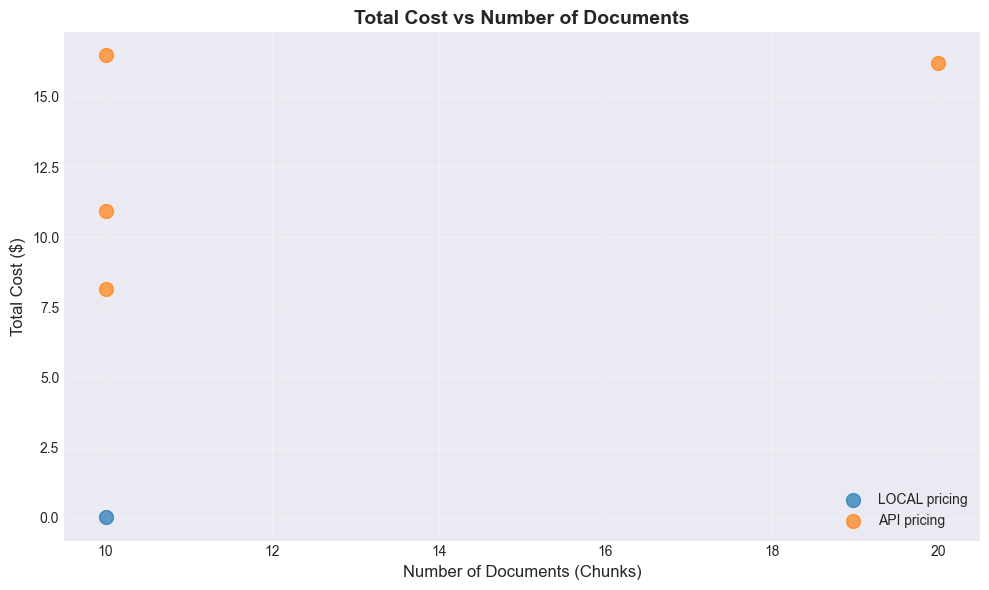

In [9]:
if not summary_df.empty:
    # Plot 1: Total cost vs number of documents
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Group by pricing mode for different colors
    for mode in summary_df['pricing_mode'].unique():
        mode_df = summary_df[summary_df['pricing_mode'] == mode]
        ax.scatter(mode_df['num_docs'], mode_df['total_cost'], 
                  label=f'{mode.upper()} pricing', s=100, alpha=0.7)
    
    ax.set_xlabel('Number of Documents (Chunks)', fontsize=12)
    ax.set_ylabel('Total Cost ($)', fontsize=12)
    ax.set_title('Total Cost vs Number of Documents', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("No data to plot.")


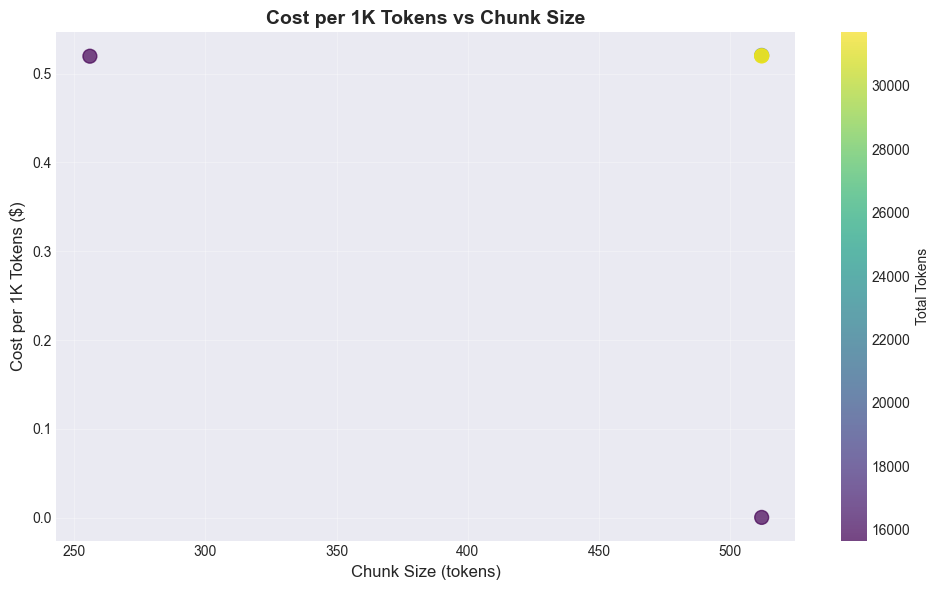

In [10]:
if not summary_df.empty:
    # Plot 2: Cost per 1K tokens vs model/chunk size
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Use chunk_size as proxy for model complexity (or use gen_model if we have different models)
    scatter = ax.scatter(summary_df['chunk_size'], summary_df['cost_per_1k_tokens'],
                        c=summary_df['total_tokens'], s=100, alpha=0.7, cmap='viridis')
    
    ax.set_xlabel('Chunk Size (tokens)', fontsize=12)
    ax.set_ylabel('Cost per 1K Tokens ($)', fontsize=12)
    ax.set_title('Cost per 1K Tokens vs Chunk Size', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Total Tokens', fontsize=10)
    
    plt.tight_layout()
    plt.show()
else:
    print("No data to plot.")


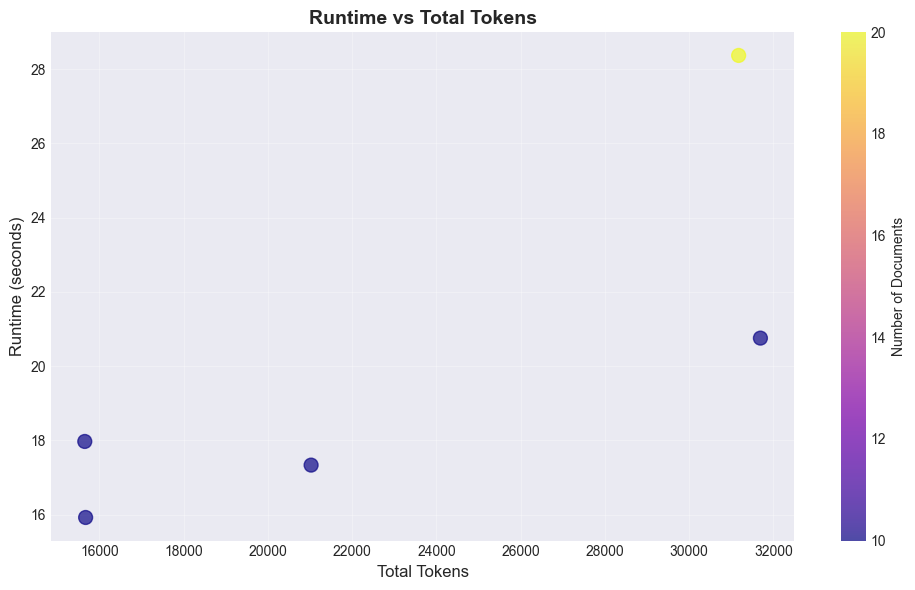

In [11]:
if not summary_df.empty:
    # Plot 3: Runtime vs tokens per experiment
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.scatter(summary_df['total_tokens'], summary_df['total_runtime_seconds'],
              s=100, alpha=0.7, c=summary_df['num_docs'], cmap='plasma')
    
    ax.set_xlabel('Total Tokens', fontsize=12)
    ax.set_ylabel('Runtime (seconds)', fontsize=12)
    ax.set_title('Runtime vs Total Tokens', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Add colorbar
    cbar = plt.colorbar(ax.collections[0], ax=ax)
    cbar.set_label('Number of Documents', fontsize=10)
    
    plt.tight_layout()
    plt.show()
else:
    print("No data to plot.")


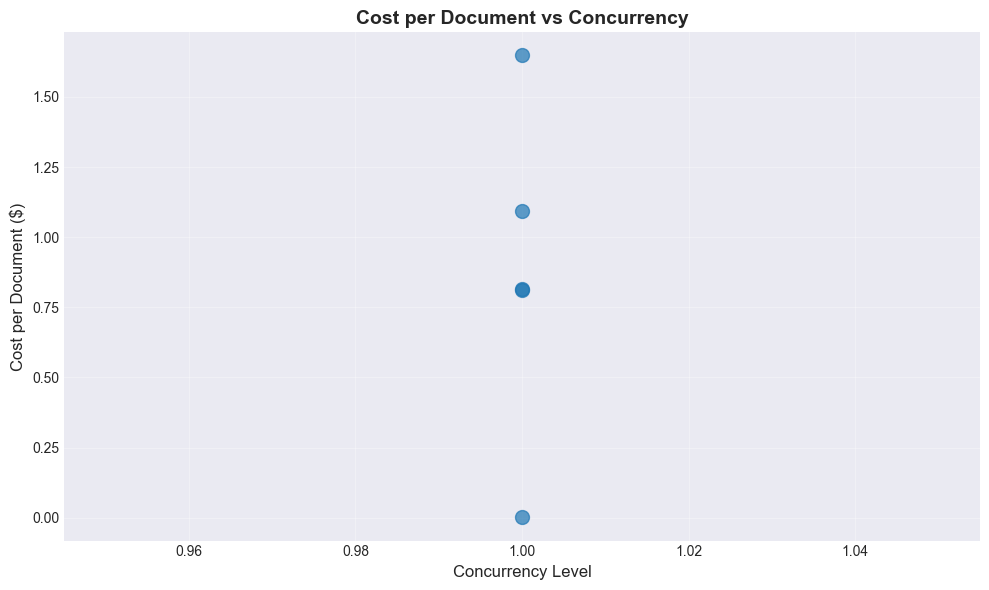

In [12]:
if not summary_df.empty:
    # Plot 4: Cost per document vs concurrency (if we have concurrency variation)
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.scatter(summary_df['concurrency'], summary_df['cost_per_document'],
              s=100, alpha=0.7)
    
    ax.set_xlabel('Concurrency Level', fontsize=12)
    ax.set_ylabel('Cost per Document ($)', fontsize=12)
    ax.set_title('Cost per Document vs Concurrency', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No data to plot.")


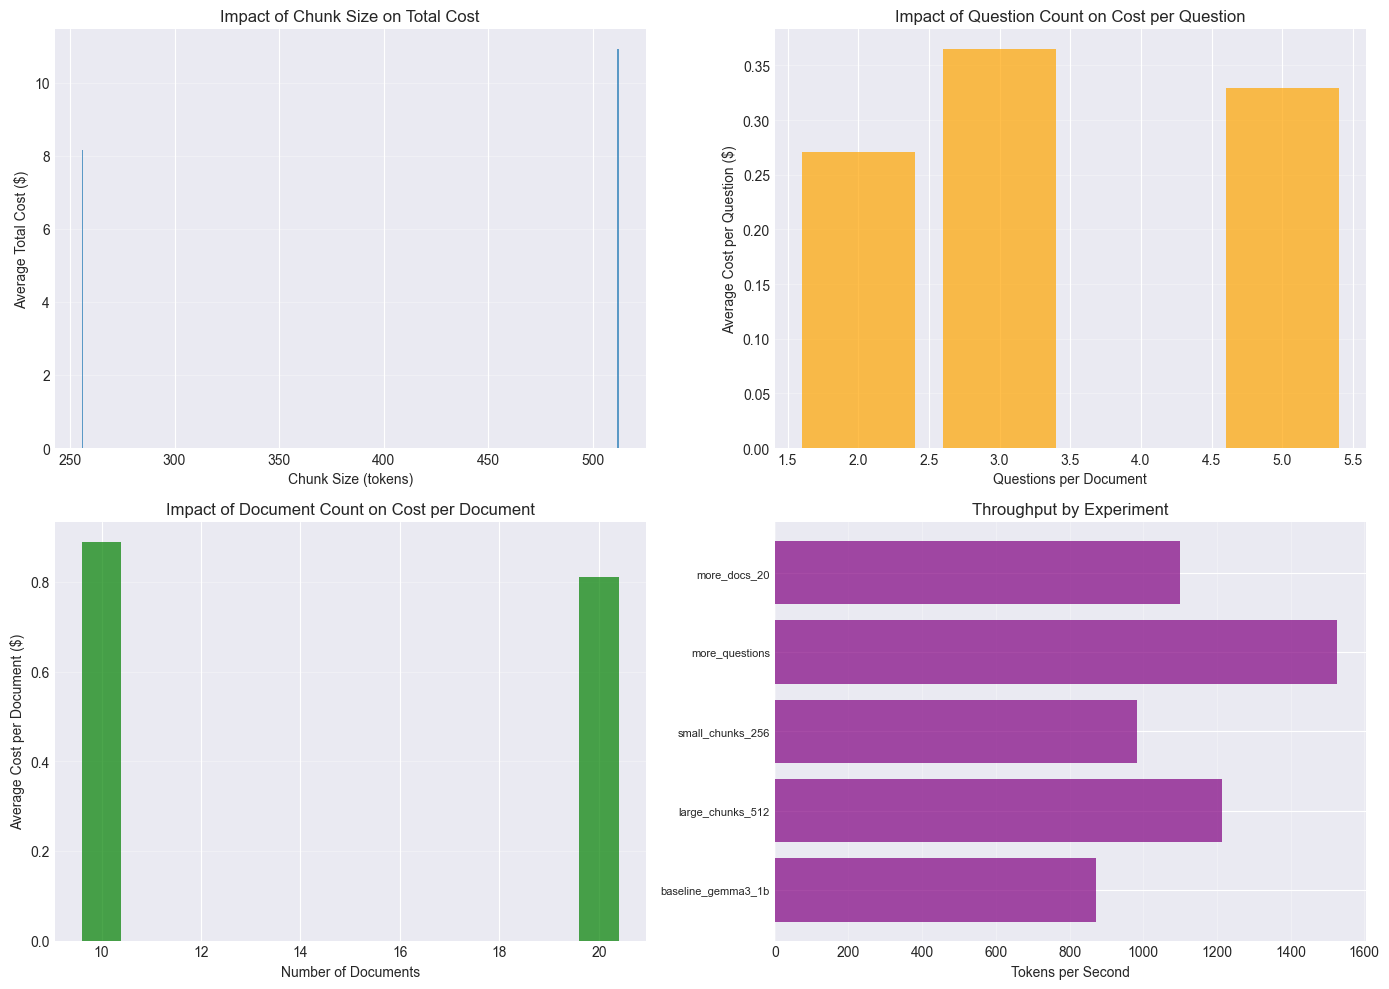

In [13]:
if not summary_df.empty:
    # Plot 5: Sensitivity analysis - chunk size impact
    # Group experiments by chunk size and show impact on cost
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Subplot 1: Chunk size vs total cost
    chunk_sizes = sorted(summary_df['chunk_size'].unique())
    costs_by_chunk = [summary_df[summary_df['chunk_size'] == cs]['total_cost'].mean() 
                      for cs in chunk_sizes]
    axes[0, 0].bar(chunk_sizes, costs_by_chunk, alpha=0.7)
    axes[0, 0].set_xlabel('Chunk Size (tokens)')
    axes[0, 0].set_ylabel('Average Total Cost ($)')
    axes[0, 0].set_title('Impact of Chunk Size on Total Cost')
    axes[0, 0].grid(True, alpha=0.3, axis='y')
    
    # Subplot 2: Number of questions vs cost per question
    if 'num_questions_per_doc' in summary_df.columns:
        questions = sorted(summary_df['num_questions_per_doc'].unique())
        cost_per_q_by_num = [summary_df[summary_df['num_questions_per_doc'] == q]['cost_per_question'].mean()
                            for q in questions]
        axes[0, 1].bar(questions, cost_per_q_by_num, alpha=0.7, color='orange')
        axes[0, 1].set_xlabel('Questions per Document')
        axes[0, 1].set_ylabel('Average Cost per Question ($)')
        axes[0, 1].set_title('Impact of Question Count on Cost per Question')
        axes[0, 1].grid(True, alpha=0.3, axis='y')
    
    # Subplot 3: Number of docs vs cost per document
    num_docs = sorted(summary_df['num_docs'].unique())
    cost_per_doc_by_num = [summary_df[summary_df['num_docs'] == n]['cost_per_document'].mean()
                           for n in num_docs]
    axes[1, 0].bar(num_docs, cost_per_doc_by_num, alpha=0.7, color='green')
    axes[1, 0].set_xlabel('Number of Documents')
    axes[1, 0].set_ylabel('Average Cost per Document ($)')
    axes[1, 0].set_title('Impact of Document Count on Cost per Document')
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    
    # Subplot 4: Tokens per second (throughput) by experiment
    axes[1, 1].barh(range(len(summary_df)), summary_df['tokens_per_second'], alpha=0.7, color='purple')
    axes[1, 1].set_yticks(range(len(summary_df)))
    axes[1, 1].set_yticklabels(summary_df['experiment_name'], fontsize=8)
    axes[1, 1].set_xlabel('Tokens per Second')
    axes[1, 1].set_title('Throughput by Experiment')
    axes[1, 1].grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()
else:
    print("No data to plot.")


## Section 8: Sensitivity Analysis

Analyze how individual parameters affect cost, tokens, and runtime.


In [14]:
if not summary_df.empty:
    print("Sensitivity Analysis: Parameter Impact")
    print("="*100)
    
    # Analyze chunk size impact
    if len(summary_df['chunk_size'].unique()) > 1:
        print("\n1. Chunk Size Impact")
        print("-" * 50)
        chunk_analysis = summary_df.groupby('chunk_size').agg({
            'total_tokens': 'mean',
            'total_runtime_seconds': 'mean',
            'total_cost': 'mean',
            'cost_per_1k_tokens': 'mean'
        }).round(2)
        print(chunk_analysis)
        
        # Calculate percentage changes
        chunk_sizes = sorted(summary_df['chunk_size'].unique())
        if len(chunk_sizes) >= 2:
            base = chunk_analysis.loc[chunk_sizes[0]]
            for cs in chunk_sizes[1:]:
                current = chunk_analysis.loc[cs]
                pct_change = ((current - base) / base * 100).round(1)
                print(f"\n  Change from {chunk_sizes[0]} to {cs} tokens:")
                print(f"    Total tokens: {pct_change['total_tokens']:+.1f}%")
                print(f"    Runtime: {pct_change['total_runtime_seconds']:+.1f}%")
                print(f"    Total cost: {pct_change['total_cost']:+.1f}%")
                print(f"    Cost per 1K tokens: {pct_change['cost_per_1k_tokens']:+.1f}%")
    
    # Analyze number of questions impact
    if len(summary_df['num_questions_per_doc'].unique()) > 1:
        print("\n\n2. Number of Questions per Document Impact")
        print("-" * 50)
        questions_analysis = summary_df.groupby('num_questions_per_doc').agg({
            'total_questions': 'mean',
            'total_tokens': 'mean',
            'total_cost': 'mean',
            'cost_per_question': 'mean'
        }).round(2)
        print(questions_analysis)
    
    # Analyze number of documents impact
    if len(summary_df['num_docs'].unique()) > 1:
        print("\n\n3. Number of Documents Impact")
        print("-" * 50)
        docs_analysis = summary_df.groupby('num_docs').agg({
            'total_tokens': 'mean',
            'total_runtime_seconds': 'mean',
            'total_cost': 'mean',
            'cost_per_document': 'mean'
        }).round(2)
        print(docs_analysis)
        
        # Calculate scaling factor
        doc_counts = sorted(summary_df['num_docs'].unique())
        if len(doc_counts) >= 2:
            base_docs = doc_counts[0]
            base_cost = docs_analysis.loc[base_docs, 'total_cost']
            for dc in doc_counts[1:]:
                current_cost = docs_analysis.loc[dc, 'total_cost']
                scaling = current_cost / base_cost
                expected_scaling = dc / base_docs
                efficiency = (expected_scaling / scaling * 100) if scaling > 0 else 0
                print(f"\n  Scaling from {base_docs} to {dc} documents:")
                print(f"    Cost scaling: {scaling:.2f}x (expected: {expected_scaling:.2f}x)")
                print(f"    Efficiency: {efficiency:.1f}%")
    
    # Compare pricing modes
    if len(summary_df['pricing_mode'].unique()) > 1:
        print("\n\n4. Pricing Mode Comparison")
        print("-" * 50)
        pricing_analysis = summary_df.groupby('pricing_mode').agg({
            'total_cost': 'mean',
            'cost_per_1k_tokens': 'mean',
            'cost_per_document': 'mean'
        }).round(4)
        print(pricing_analysis)
else:
    print("No data available for sensitivity analysis.")


Sensitivity Analysis: Parameter Impact

1. Chunk Size Impact
--------------------------------------------------
            total_tokens  total_runtime_seconds  total_cost  \
chunk_size                                                    
256              15673.0                  15.93        8.14   
512              24886.5                  21.11       10.91   

            cost_per_1k_tokens  
chunk_size                      
256                       0.52  
512                       0.39  

  Change from 256 to 512 tokens:
    Total tokens: +58.8%
    Runtime: +32.5%
    Total cost: +34.0%
    Cost per 1K tokens: -25.0%


2. Number of Questions per Document Impact
--------------------------------------------------
                       total_questions  total_tokens  total_cost  \
num_questions_per_doc                                              
2                                26.67      20833.67        8.12   
3                                30.00      21026.00       10.94   
5 